In [1]:
import pandas as pd

pd.set_option(
    "display.max_colwidth", 81
)  # maximal fen length without the halfmove and fullmove clocks
pd.set_option("display.memory_usage", "deep")

df = pd.read_csv("data/chessData.csv", nrows=None)

# all columns to lower case
df.columns = df.columns.str.lower()
df.columns

Index(['fen', 'evaluation'], dtype='object')

In [2]:
# dataframe is quite big :O, but has no null-rows
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12958035 entries, 0 to 12958034
Data columns (total 2 columns):
 #   Column      Non-Null Count     Dtype 
---  ------      --------------     ----- 
 0   fen         12958035 non-null  object
 1   evaluation  12958035 non-null  object
dtypes: object(2)
memory usage: 1.9 GB


# Investigate data

It looks like the evaluation is all from whites position, because, the sign in the evaluation is not fluctuating constantly. It also looks like the beginning is just one game, however this cannot be true for the whole dataset, as it barely has repeated positions (It should actually not have any, but I'm not sure this is true, anyway we will introduce collisions later anyway)

In [3]:
df.iloc[:31]

,fen,evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKBNR w KQkq - 0 3,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQKBNR b KQkq - 1 3,-26
5,rnbqkb1r/ppp2ppp/4pn2/3p4/3PP3/8/PPPN1PPP/R1BQKBNR w KQkq - 2 4,+50
6,rnbqkb1r/ppp2ppp/4pn2/3pP3/3P4/8/PPPN1PPP/R1BQKBNR b KQkq - 0 4,+10
7,rnbqkb1r/pppn1ppp/4p3/3pP3/3P4/8/PPPN1PPP/R1BQKBNR w KQkq - 1 5,+75
8,rnbqkb1r/pppn1ppp/4p3/3pP3/3P1P2/8/PPPN2PP/R1BQKBNR b KQkq - 0 5,+52
9,rnbqkb1r/pp1n1ppp/4p3/2ppP3/3P1P2/8/PPPN2PP/R1BQKBNR w KQkq - 0 6,+52


The data seems to only indicate en passant square if it's possible (judging by the frequency) and castling rights follow the order KQkq

In [4]:
# frequency of fen-strings with en passant squares

frac_en_passant = len(df[(df["fen"].str.split().str[3] != "-")]) / len(df)
print(f"Fraction of fen with en passant: {frac_en_passant}")

# all castling rules are '-' or a subsequence of 'KQkq'
pattern = r"^-$|^(K)?(Q)?(k)?(q)?$"

all_KQkq_order = df["fen"].str.split().str[2].str.match(pattern).all()
print(f"All fen's follow KQkq order: {all_KQkq_order}")

Fraction of fen with en passant: 0.0016005513181589646
All fen's follow KQkq order: True


# Data Engineering

## Make eval 'us' vs 'them'

We change eval string so that it shows current player's advantage (us), not white's.

In [5]:
def swap_evaluation_sign(evaluation):
    if evaluation == "0":
        return evaluation
    if evaluation.startswith("+"):
        return "-" + evaluation[1:]
    if evaluation.startswith("-"):
        return "+" + evaluation[1:]
    if evaluation.startswith("#+"):
        return "#-" + evaluation[2:]
    elif evaluation.startswith("#-"):
        return "#+" + evaluation[2:]
    else:
        raise ValueError(f"Unknown evaluation: {evaluation}")


# apply is slow so this takes a bit
df["evaluation"] = df.apply(
    lambda row: (
        swap_evaluation_sign(row["evaluation"])
        if row["fen"].split()[1] == "b"
        else row["evaluation"]
    ),
    axis=1,
)

In [6]:
# it has seemed to have worked, evaluation signs are now flipping
df.iloc[20:30]

,fen,evaluation
20,r1b1k2r/pp1n2pp/1qn1pp2/3pP3/1b1P1P2/3B1N2/PP1BN1PP/R2QK2R b KQkq - 5 11,-93
21,r1b1k2r/pp1n2pp/1qn1p3/3pp3/1b1P1P2/3B1N2/PP1BN1PP/R2QK2R w KQkq - 0 12,+263
22,r1b1k2r/pp1n2pp/1qn1p3/3pP3/1b1P4/3B1N2/PP1BN1PP/R2QK2R b KQkq - 0 12,-201
23,r1b2rk1/pp1n2pp/1qn1p3/3pP3/1b1P4/3B1N2/PP1BN1PP/R2QK2R w KQ - 1 13,+248
24,r1b2rk1/pp1n2pp/1qn1p3/3pP3/1b1P4/P2B1N2/1P1BN1PP/R2QK2R b KQ - 0 13,-169
25,r1b2rk1/pp1nb1pp/1qn1p3/3pP3/3P4/P2B1N2/1P1BN1PP/R2QK2R w KQ - 1 14,+238
26,r1b2rk1/pp1nb1pp/1qn1p3/3pP3/3P4/P2B1N2/1PQBN1PP/R3K2R b KQ - 2 14,-101
27,r1b3k1/pp1nb1pp/1qn1p3/3pP3/3P4/P2B1r2/1PQBN1PP/R3K2R w KQ - 0 15,+21
28,r1b3k1/pp1nb1pp/1qn1p3/3pP3/3P4/P2B1P2/1PQBN2P/R3K2R b KQ - 0 15,-134
29,r1b3k1/pp1nb1pp/1q2p3/3pP3/3n4/P2B1P2/1PQBN2P/R3K2R w KQ - 0 16,0


# Split `evaluation` in `advantage` and `mate_in`

In [7]:
# separate forced mates and eval cleanly
s = df["evaluation"]

df["mate_for_us"] = s.str.startswith("#+")
df["mate_for_them"] = s.str.startswith("#-")
df["mate_in"] = s.where(df["mate_for_us"] | df["mate_for_them"]).str[2:].astype("Int64")
df["advantage"] = s.where(~df["mate_for_us"] & ~df["mate_for_them"]).astype("Int64")

df.drop(columns=["evaluation"], inplace=True)

In [8]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12958035 entries, 0 to 12958034
Data columns (total 5 columns):
 #   Column         Non-Null Count     Dtype 
---  ------         --------------     ----- 
 0   fen            12958035 non-null  object
 1   mate_for_us    12958035 non-null  bool  
 2   mate_for_them  12958035 non-null  bool  
 3   mate_in        190154 non-null    Int64 
 4   advantage      12767881 non-null  Int64 
dtypes: Int64(2), bool(2), object(1)
memory usage: 1.5 GB


## Removing clocks and flipping board

For training I want to use mirrored positions. However, I also want to ensure no leakage of information, so I have to clean mirrored and duplicated positions.

In [9]:
def flip_board(board_fen: str):
    ranks = board_fen.split("/")
    flipped_ranks = [rank[::-1] for rank in ranks]
    return "/".join(flipped_ranks)


def flip_castling(castling: str):
    if castling == "-":
        return "-"

    orig_K = "K" in castling
    orig_Q = "Q" in castling
    orig_k = "k" in castling
    orig_q = "q" in castling

    new_castling = ""
    if orig_Q:
        new_castling += "K"
    if orig_K:
        new_castling += "Q"
    if orig_q:
        new_castling += "k"
    if orig_k:
        new_castling += "q"
    return new_castling


def flip_en_passant(ep_square):
    if ep_square == "-":
        return "-"

    new_file = chr(ord("a") + ord("h") - ord(ep_square[0]))
    return new_file + ep_square[1]


def canonical_form(fen):
    # getting rid of the clocks
    board, turn, castling, en_passant, _, _ = fen.split()

    board_flipped = flip_board(board)
    castling_flipped = flip_castling(castling)
    en_passant_flipped = flip_en_passant(en_passant)

    original = (board, turn, castling, en_passant)
    flipped = (board_flipped, turn, castling_flipped, en_passant_flipped)

    chosen = min(original, flipped)
    return " ".join(chosen)


df["canonical_fen"] = df["fen"].apply(canonical_form)
df

,fen,mate_for_us,mate_for_them,mate_in,advantage,canonical_fen
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1,False,False,<NA>,10,rnbkqbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBKQBNR b KQkq -
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2,False,False,<NA>,56,rnbkqbnr/ppp1pppp/3p4/8/3P4/8/PPP1PPPP/RNBKQBNR w KQkq -
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2,False,False,<NA>,9,rnbkqbnr/ppp1pppp/3p4/8/3PP3/8/PPP2PPP/RNBKQBNR b KQkq -
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKBNR w KQkq - 0 3,False,False,<NA>,52,rnbkqbnr/ppp2ppp/3p4/4p3/3PP3/8/PPP2PPP/RNBKQBNR w KQkq -
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQKBNR b KQkq - 1 3,False,False,<NA>,26,rnbkqbnr/ppp2ppp/3p4/4p3/3PP3/8/PPP1NPPP/RNBKQB1R b KQkq -
...,...,...,...,...,...,...
12958030,r1bqkb1r/pp3ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1PP/RNB1K2R b KQkq - 1 10,False,False,<NA>,-6,r1bkqb1r/ppp3pp/3p1nn1/3Pp3/2P1P3/2N3B1/PP1Q2PP/R2K1BNR b KQkq -
12958031,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1PP/RNB1K2R w KQkq - 2 11,False,False,<NA>,84,r1bkq2r/ppp1b1pp/3p1nn1/3Pp3/2P1P3/2N3B1/PP1Q2PP/R2K1BNR w KQkq -
12958032,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1BN2N2/PP2Q1PP/R1B1K2R b KQkq - 3 11,False,False,<NA>,0,r1bkq2r/ppp1b1pp/3p1nn1/3Pp3/2P1P3/2N2NB1/PP1Q2PP/R2K1B1R b KQkq -
12958033,r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q1PP/R1B1K2R w KQkq - 4 12,False,False,<NA>,115,r1bkq2r/ppp1b1pp/3p2n1/3Pp2n/2P1P3/2N2NB1/PP1Q2PP/R2K1B1R w KQkq -


Throwing away clocks, can actually lead to changes of evaluation. If the clock is high, then a winnable position becomes a draw. We have to live with this inconsistency in the data, but in a few cases we can find a substitute. Here is an example of such a case

In [10]:
inconsistent_mates = (
    df.groupby("canonical_fen")["mate_for_us"].nunique().loc[lambda s: s > 1]
)

mate_and_no_advantage = df.loc[
    df["canonical_fen"].isin(inconsistent_mates.index) & (df["advantage"] == 0),
    "canonical_fen",
].iloc[0]

It looks like we have a winning strategy in this position, but both entries with equivalent board (under flipping) have different evaluations of this situation. I think it's because in one of the examples the halfclock is too high to force a win in time

                                        fen  mate_for_us  mate_for_them  \
4860552  8/2N5/8/8/k1KB4/8/8/8 w - - 87 102        False          False   
9342542   8/5N2/8/8/4BK1k/8/8/8 w - - 65 89         True          False   

         mate_in  advantage                canonical_fen  
4860552     <NA>          0  8/2N5/8/8/k1KB4/8/8/8 w - -  
9342542       12       <NA>  8/2N5/8/8/k1KB4/8/8/8 w - -  


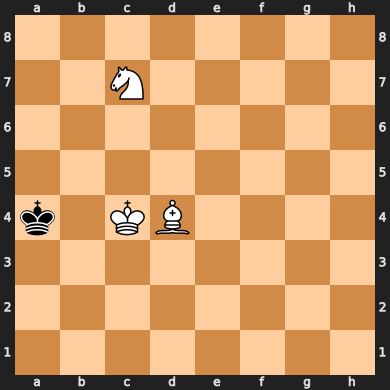

In [11]:
import chess

print(df[df["canonical_fen"] == mate_and_no_advantage])

chess.Board(mate_and_no_advantage.split()[0])

As our NN does not have the clock information we will deal with this by prioritizing 'mate_in' over 'eval' if the former is set we use it and the latter is set to `NA`

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12958035 entries, 0 to 12958034
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   fen            object
 1   mate_for_us    bool  
 2   mate_for_them  bool  
 3   mate_in        Int64 
 4   advantage      Int64 
 5   canonical_fen  object
dtypes: Int64(2), bool(2), object(2)
memory usage: 2.7 GB


In [13]:
df = df.groupby("canonical_fen", as_index=False).agg(
    mate_for_us=("mate_for_us", "any"),
    mate_for_them=("mate_for_them", "any"),
    advantage=("advantage", "mean"),
)

# delete evals if mate exists
df["advantage"] = df["advantage"].mask(df["mate_for_us"] | df["mate_for_them"])

In [14]:
# did we break anything?

if (df["mate_for_us"] & df["mate_for_them"]).sum() != 0:
    raise ValueError("mate_for_us and mate_for them not exclusive")
if not (df["mate_for_us"] | df["mate_for_them"] == df["advantage"].isna()).all():
    raise ValueError("advantage and mates are not exclusive")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12951861 entries, 0 to 12951860
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   canonical_fen  object 
 1   mate_for_us    bool   
 2   mate_for_them  bool   
 3   advantage      Float64
dtypes: Float64(1), bool(2), object(1)
memory usage: 1.3 GB


### Filling `advantage`

let's fill advantage with a hugh value if mate

In [16]:
max_advantage = df["advantage"].abs().max()
max_advantage

np.float64(15319.0)

In [17]:
extra_for_mate = 1000
df.loc[df["mate_for_us"], "advantage"] = max_advantage + extra_for_mate
df.loc[df["mate_for_them"], "advantage"] = -(max_advantage + extra_for_mate)

In [18]:
df.drop(columns=["mate_for_us", "mate_for_them"], inplace=True)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12951861 entries, 0 to 12951860
Data columns (total 2 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   canonical_fen  12951861 non-null  object 
 1   advantage      12951861 non-null  Float64
dtypes: Float64(1), object(1)
memory usage: 1.3 GB


# Plot of advantage

Let's check visually if advantage makes sense

<Axes: xlabel='advantage', ylabel='Count'>

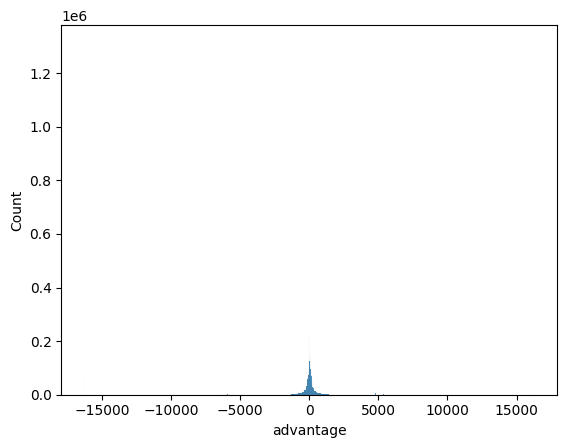

In [ ]:
import seaborn as sns

sns.histplot(df["advantage"])

In [22]:
df.describe()

,advantage
count,12951861.0
mean,15.940283
std,2135.108431
min,-16319.0
25%,-82.0
50%,13.0
75%,140.0
max,16319.0


# We're done. Let's save

In [20]:
import pandas as pd

df = df.sample(frac=1, random_state=0)

# 1. Chess test set
chess_test = df.iloc[:100_000]
chess_test.to_csv("data/cleaned/chess_test.csv", index=False)

# 2. Remaining data -> full train+val
train_val_full = df.iloc[100_000:]
train_val_full.to_csv("data/cleaned/chess_train_val_full.csv", index=False)

# 3. Small subset (10% of remaining)
train_val_small = train_val_full.sample(frac=0.1, random_state=0)
train_val_small.to_csv("data/cleaned/chess_train_val_small.csv", index=False)

In [21]:
df

,canonical_fen,advantage
2143547,1k3r1r/2p3q1/1p2Q2b/1P3n2/4N1pp/4P3/P1B3PP/R4RK1 w - -,-365.0
3093905,1k6/2n3p1/p3p2p/n2bPp1P/7R/P2r1N2/1BB3P1/1K6 b - -,264.0
12118277,k2rq2r/pp5p/3pBb2/5Pp1/4Q3/1N6/PP3B1P/1KR1n3 w - -,536.0
4236504,1kr1q2r/pppbb1pp/n2p1n2/5p2/2PN4/2N1BP2/PP1QP1PP/1KR2B1R b - -,-5.0
10982565,8/3r4/1KN5/3r1k1p/R6P/8/8/8 b - -,387.0
...,...,...
5157699,1kr2r2/pbppb2p/1pn1p3/q7/2PP2n1/P1NB1NB1/1P2QPP1/1KR4R b - -,-186.0
2215104,1k3r2/1pp3Q1/p2n4/4p3/4p1P1/2P5/PP2q1NK/8 w - -,-169.0
1484405,1k2q1r1/pbpp3r/1pn1p3/2b1Pp1p/2P4N/PP3BP1/1BP4P/1K1RQR2 b - -,44.0
12888623,r3k1nr/pp3pp1/2pb1np1/5P2/8/6NP/PPP1B1P1/R1B1K2R w KQkq -,-47.0
